In [7]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.dates as mdates
import datetime as dt

from statsmodels.graphics.tsaplots import acf, pacf
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller



# BTC

## Step #1: Read Data

In [8]:
# Read data
df = pd.read_csv('../../../Dataset/BTC-USD.csv', parse_dates=['Date'])
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-03-01,10385.000000,11052.299805,10352.700195,10951.000000,10951.000000,7317279744
1,2018-03-02,10977.400391,11189.000000,10850.099609,11086.400391,11086.400391,7620590080
2,2018-03-03,11101.900391,11528.200195,11002.400391,11489.700195,11489.700195,6690570240
3,2018-03-04,11497.400391,11512.599609,11136.099609,11512.599609,11512.599609,6084149760
4,2018-03-05,11532.400391,11704.099609,11443.900391,11573.299805,11573.299805,6468539904
...,...,...,...,...,...,...,...
2280,2024-05-28,69392.195313,69514.640625,67227.156250,68296.218750,68296.218750,32722265965
2281,2024-05-29,68296.351563,68852.460938,67101.492188,67578.093750,67578.093750,26707072906
2282,2024-05-30,67576.085938,69500.539063,67118.078125,68364.992188,68364.992188,29509712534
2283,2024-05-31,68362.515625,68999.562500,66633.421875,67491.414063,67491.414063,27387283769


## Step #2: Explore the Data

In [9]:
# Dataset Description
df = df.set_index('Date')
print(f"Dataset Shape: {df.shape}")
print(f"Dataset Info: {df.info()}")
print(f"Dataset Describe: {df.describe()}")

Dataset Shape: (2285, 6)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2285 entries, 2018-03-01 to 2024-06-01
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2285 non-null   float64
 1   High       2285 non-null   float64
 2   Low        2285 non-null   float64
 3   Close      2285 non-null   float64
 4   Adj Close  2285 non-null   float64
 5   Volume     2285 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 125.0 KB
Dataset Info: None
Dataset Describe:                Open          High           Low         Close     Adj Close  \
count   2285.000000   2285.000000   2285.000000   2285.000000   2285.000000   
mean   24460.039968  25010.063700  23873.494115  24483.298446  24483.298446   
std    18234.366115  18677.832579  17742.882905  18251.603919  18251.603919   
min     3236.274658   3275.377930   3191.303467   3236.761719   3236.761719   
25%     8603.428711   8755.852539   8374.323242

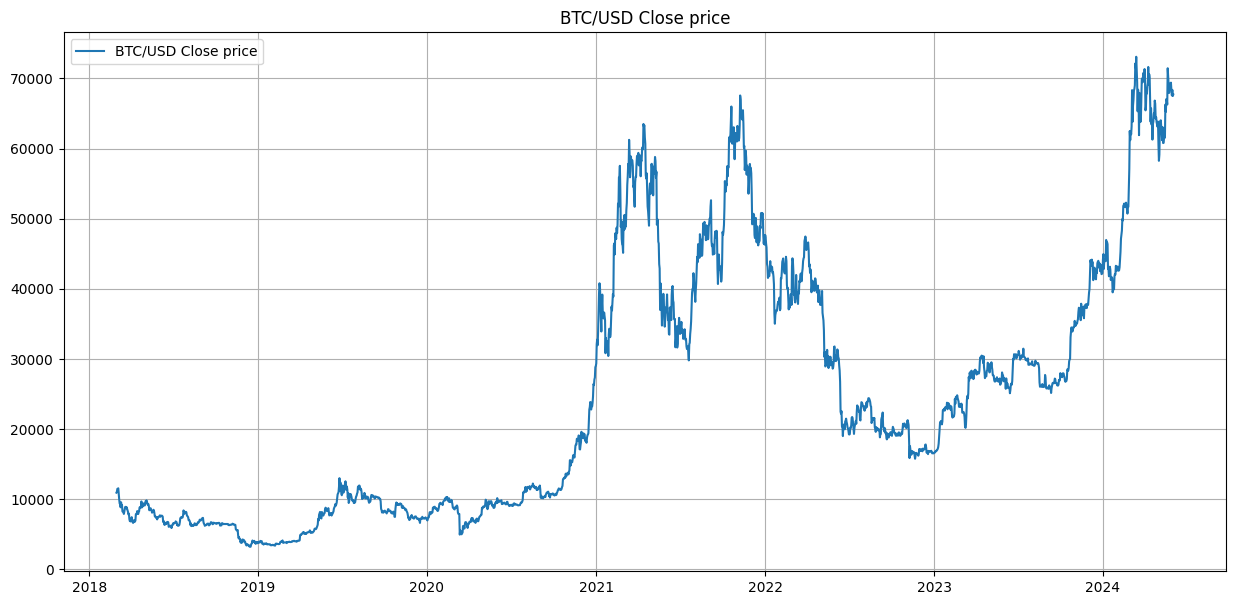

In [10]:
# Plotting data
plt.figure(figsize=(15, 7))
plt.plot(df.Close, label='BTC/USD Close price')
plt.title('BTC/USD Close price')
plt.grid()
plt.legend()
plt.show()


## Step #3: Feature Engineering

In [11]:
# Feature Engineering
def createFeatures(df):
    df = pd.DataFrame(df)

    
    # df['Close_Diff'] = df['Adj Close'].diff()
        
    # Moving averages - different periods
    df['MA200'] = df['Close'].rolling(window=200).mean() 
    df['MA100'] = df['Close'].rolling(window=100).mean() 
    df['MA50'] = df['Close'].rolling(window=50).mean() 
    df['MA26'] = df['Close'].rolling(window=26).mean() 
    df['MA20'] = df['Close'].rolling(window=20).mean() 
    df['MA12'] = df['Close'].rolling(window=12).mean() 
    
    # SMA Differences - different periods
    df['DIFF-MA200-MA50'] = df['MA200'] - df['MA50']
    df['DIFF-MA200-MA100'] = df['MA200'] - df['MA100']
    df['DIFF-MA200-CLOSE'] = df['MA200'] - df['Close']
    df['DIFF-MA100-CLOSE'] = df['MA100'] - df['Close']
    df['DIFF-MA50-CLOSE'] = df['MA50'] - df['Close']
    
    # Moving Averages on high, lows, and std - different periods
    # df['MA200_low'] = df['Low'].rolling(window=200).min()
    # df['MA14_low'] = df['Low'].rolling(window=14).min()
    # df['MA200_high'] = df['High'].rolling(window=200).max()
    # df['MA14_high'] = df['High'].rolling(window=14).max()
    df['MA20dSTD'] = df['Close'].rolling(window=20).std() 
    
    # Exponential Moving Averages (EMAS) - different periods
    df['EMA12'] = df['Close'].ewm(span=12, adjust=False).mean()
    df['EMA20'] = df['Close'].ewm(span=20, adjust=False).mean()
    df['EMA26'] = df['Close'].ewm(span=26, adjust=False).mean()
    df['EMA100'] = df['Close'].ewm(span=100, adjust=False).mean()
    df['EMA200'] = df['Close'].ewm(span=200, adjust=False).mean()

    # Shifts (one day before and two days before)
    df['close_shift-1'] = df.shift(-1)['Close']
    df['close_shift-2'] = df.shift(-2)['Close']

    # Bollinger Bands
    df['Bollinger_Upper'] = df['MA20'] + (df['MA20dSTD'] * 2)
    df['Bollinger_Lower'] = df['MA20'] - (df['MA20dSTD'] * 2)
    df['Bollinger_Middle'] = df['MA20'] 
    
    # Relative Strength Index (RSI)
    # df['K-ratio'] = 100*((df['Close'] - df['MA14_low']) / (df['MA14_high'] - df['MA14_low']) )
    # Relative Strength Index (RSI) not using the K-ratio
    # df['RSI'] = df['K-ratio'].rolling(window=3).mean() 

    # Moving Average Convergence/Divergence (MACD)
    df['MACD'] = df['EMA12'] - df['EMA26']
    
    # Replace nas 
    nareplace = df.at[df.index.max(), 'Close']    
    df.fillna((nareplace), inplace=True)

    return df

                   Close  MACD_shift-1  Bollinger_Upper_shift-1  Bollinger_Lower_shift-1  MA26_shift-1  EMA20_shift-1
Date                                                                                                                 
2024-05-28  68296.218750   1513.737899             72908.442357             58875.404127  65125.811749   66876.859258
2024-05-29  67578.093750   1432.292774             72974.761404             59519.912815  65478.611178   67012.036352
2024-05-30  68364.992188   1294.873741             73051.203319             59896.284182  65658.928786   67065.946581
2024-05-31  67491.414063   1235.225386             72903.637919             60801.071066  65830.987230   67189.665210
2024-06-01  67706.937500   1104.728558             72526.151854             61848.327443  65964.074970   67218.403196
                  Close  MACD_shift-1  Bollinger_Upper_shift-1  Bollinger_Lower_shift-1  MA26_shift-1  EMA20_shift-1
Date                                                     

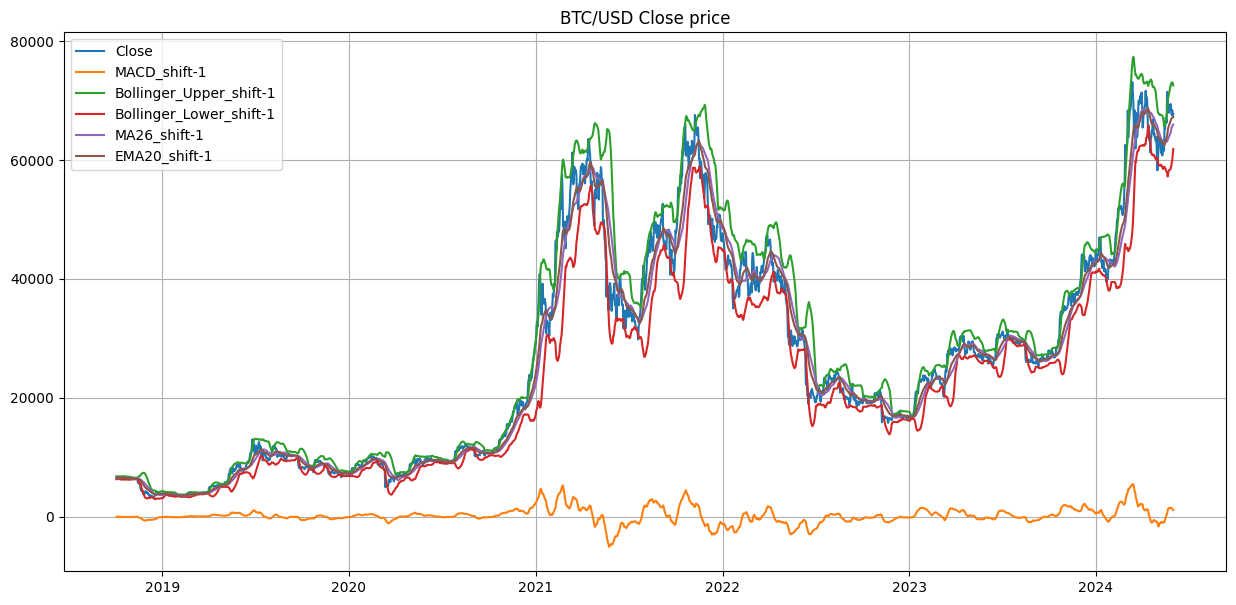

In [12]:
# List of considered Features
FEATURES = [
            # 'High',
            # 'Low',
            # 'Open',
            'Close',
            # 'Volume',
#             'Day',
#             'Month',
#             'Year',
            # 'Adj Close',
#              'close_shift-1',
#              'close_shift-2',
            'MACD',
            # 'RSI',
            # 'MA200',
#             'MA200_high',
#             'MA200_low',
            'Bollinger_Upper',
            'Bollinger_Lower',
            # 'MA100',            
#             'MA50',
            'MA26',
#             'MA14_low',
#             'MA14_high',
            # 'MA12',
            'EMA20',
            # 'EMA100',
#             'EMA200',
#               'DIFF-MA200-MA50',
#               'DIFF-MA200-MA100',
#             'DIFF-MA200-CLOSE',
#             'DIFF-MA100-CLOSE',
#             'DIFF-MA50-CLOSE',
            # 'MA20dSTD',
            # 'Close_Diff',
            # 'K-ratio'
           ]

# Create the dataset with features
df_features = createFeatures(df)

# Shift the timeframe by 10 month -> Start date is 2010-11-01
use_start_date = pd.to_datetime("2018-10-01")
df_features = df_features[df_features.index > use_start_date].copy()

# Filter the data to the list of FEATURES
df_filtered = df_features[FEATURES].copy()

df_original = df_filtered.copy()

# Create shifted features
for feature in FEATURES:
    if feature != 'Close':
        df_filtered[feature + '_shift-1'] = df_filtered[feature].shift(1)
        df_filtered = df_filtered.drop(feature, axis=1)

df_filtered = df_filtered.dropna()


print(df_filtered.tail().to_string())
print(df_filtered.head().to_string())
print(df_original.head().to_string())
print(df_original.tail().to_string())

# Create the lineplot
plt.figure(figsize=(15, 7))
plt.plot(df_filtered)
plt.title('BTC/USD Close price')
plt.grid()
plt.legend(df_filtered.columns)
plt.show()


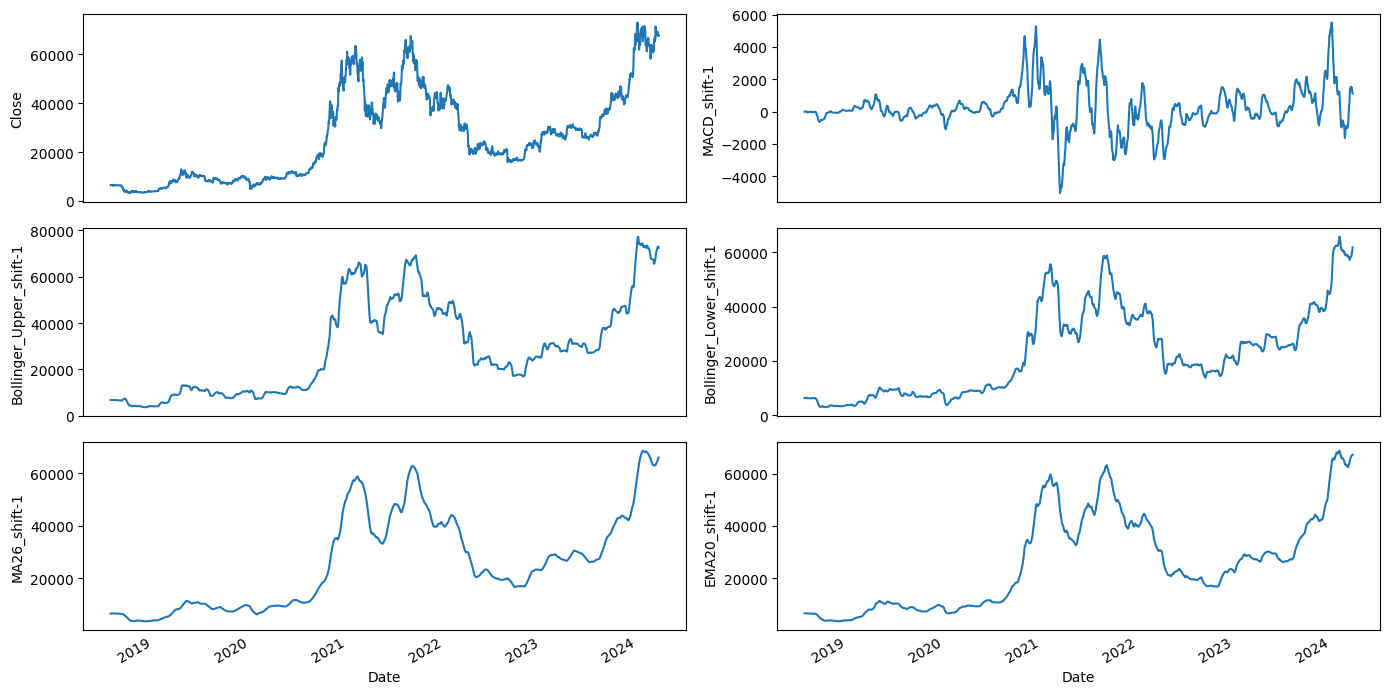

In [13]:
# Plot line charts
df_plot = df_filtered.copy()

ncols = 2
nrows = int(round(df_plot.shape[1] / ncols, 0))

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(14, 7))
for i, ax in enumerate(fig.axes):
        sns.lineplot(data = df_plot.iloc[:, i], ax=ax)
        ax.tick_params(axis="x", rotation=30, labelsize=10, length=0)
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
fig.tight_layout()
plt.show()

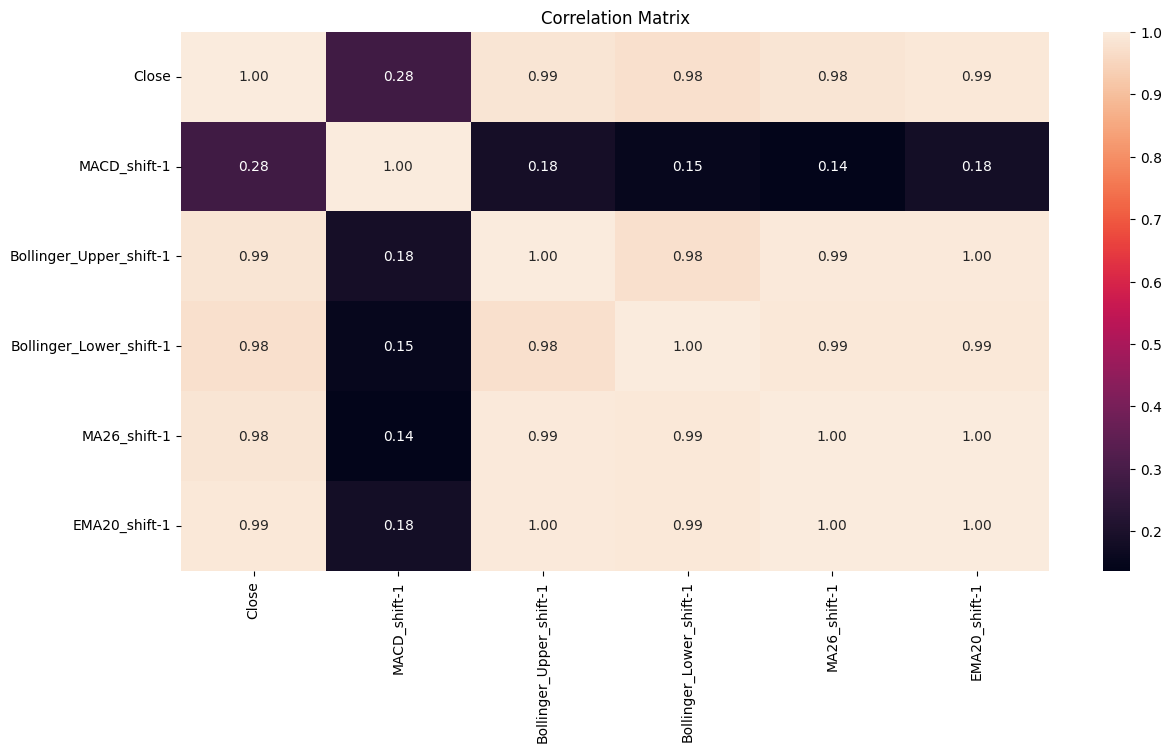

In [14]:
# Coorelation Matrix
plt.figure(figsize=(14, 7))
sns.heatmap(df_filtered.corr(), annot=True, fmt=".2f")
plt.title('Correlation Matrix')
plt.show()


In [15]:
# Granger causality test to check if the past values of the time series affect the current value of the time series
from statsmodels.tsa.stattools import grangercausalitytests
maxlag = 24
test = 'ssr_chi2test'

def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1], 4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(df, variables = df.columns)



,Open_x,High_x,Low_x,Close_x,Adj Close_x,Volume_x
Open_y,1.0000,0.0000,0.0000,0.0,0.0,0.0
High_y,0.0000,1.0000,0.0000,0.0,0.0,0.0
Low_y,0.0000,0.0000,1.0000,0.0,0.0,0.0
Close_y,0.0005,0.0001,0.0171,1.0,1.0,0.0
Adj Close_y,0.0005,0.0001,0.0171,1.0,1.0,0.0
Volume_y,0.0000,0.0000,0.0000,0.0,0.0,1.0


## Step #4: Train & Test split

In [16]:
# Train-Test Split
def split_data(df, test_size=None):
    test_size = 0.2 if test_size is None else test_size
    split_row = len(df) - int(test_size * len(df))
    train_set = df.iloc[:split_row].copy()
    test_set = df.iloc[split_row:].copy()
    return train_set, test_set

df_train, df_test = split_data(df_filtered, test_size=0.3) 

In [17]:
print(df_filtered.shape)
print(df_train.shape)
print(df_test.shape)

(2069, 6)
(1449, 6)
(620, 6)


## Step #5: Model Specification

**VAR**

**1. Check for stationary**

In [18]:
# Agugmented Dickey-Fuller test
def adf_test(dataset, name):
    dftest = adfuller(dataset, autolag='AIC', regression='ct')
    print(f"ADF Test on '{name}' -> p-value: {dftest[1]:.3f}")
    # print("1. ADF : ",dftest[0])
    # Print dataset cols
    # print("3. Num Of Lags : ", dftest[2])
    # print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
    # # print("5. Critical Values :")
    # for key, val in dftest[4].items():
    #    print("\t",key, ": ", val)
    if (dftest[0] < dftest[4]["5%"] or dftest[0] < dftest[4]["1%"] or dftest[0] < dftest[4]["10%"]):
        print ("\033[92mReject Ho - Time Series is Stationary\033[0m")
        return True
    else:
        print ("\033[91mFailed to Reject Ho - Time Series is Non-Stationary\033[0m")
        return False
      

In [19]:
# ADF Test on each column of 1st Differences Dataframe
for col in df_train.columns:
    adf_test(df_train[col], col)

ADF Test on 'Close' -> p-value: 0.915
Failed to Reject Ho - Time Series is Non-Stationary
ADF Test on 'MACD_shift-1' -> p-value: 0.003
Reject Ho - Time Series is Stationary
ADF Test on 'Bollinger_Upper_shift-1' -> p-value: 0.950
Failed to Reject Ho - Time Series is Non-Stationary
ADF Test on 'Bollinger_Lower_shift-1' -> p-value: 0.810
Failed to Reject Ho - Time Series is Non-Stationary
ADF Test on 'MA26_shift-1' -> p-value: 0.861
Failed to Reject Ho - Time Series is Non-Stationary
ADF Test on 'EMA20_shift-1' -> p-value: 0.595
Failed to Reject Ho - Time Series is Non-Stationary


In [20]:
# 1st difference
df_differenced = df_train.diff().dropna()

In [21]:
# ADF Test on each column of 1st Differences Dataframe
for col in df_differenced.columns:
    adf_test(df_differenced[col], col)
    

ADF Test on 'Close' -> p-value: 0.000
Reject Ho - Time Series is Stationary
ADF Test on 'MACD_shift-1' -> p-value: 0.000
Reject Ho - Time Series is Stationary
ADF Test on 'Bollinger_Upper_shift-1' -> p-value: 0.000
Reject Ho - Time Series is Stationary
ADF Test on 'Bollinger_Lower_shift-1' -> p-value: 0.000
Reject Ho - Time Series is Stationary
ADF Test on 'MA26_shift-1' -> p-value: 0.000
Reject Ho - Time Series is Stationary
ADF Test on 'EMA20_shift-1' -> p-value: 0.001
Reject Ho - Time Series is Stationary


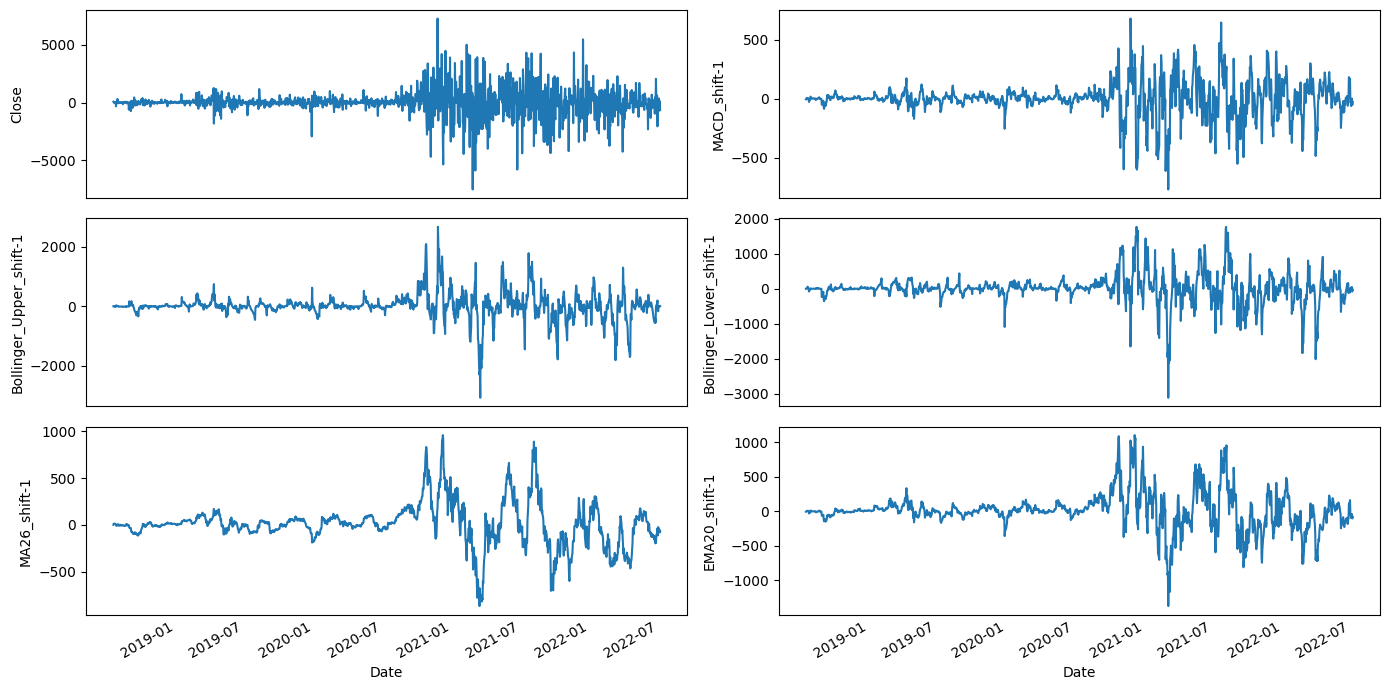

In [22]:
# Plot line charts
df_plot = df_differenced.copy()

ncols = 2
nrows = int(round(df_plot.shape[1] / ncols, 0))

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(14, 7))
for i, ax in enumerate(fig.axes):
        sns.lineplot(data = df_plot.iloc[:, i], ax=ax)
        ax.tick_params(axis="x", rotation=30, labelsize=10, length=0)
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
fig.tight_layout()
plt.show()

Text(0.5, 1.0, 'ACF')

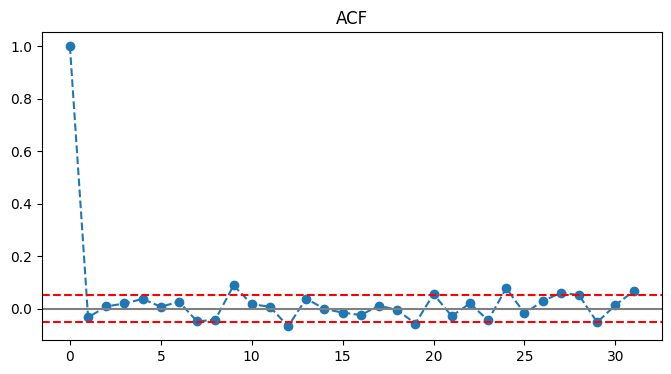

In [23]:
import statsmodels.tsa.stattools as ts
acf_plot = ts.acf(df_differenced['Close'])
# Plot ACF
plt.figure(figsize=(8, 4))
plt.plot(acf_plot, marker='o', linestyle='--')
plt.axhline(y=0, color='gray')
plt.axhline(y=-1.96/np.sqrt(len(df_differenced)), color='red', linestyle='--')
plt.axhline(y=1.96/np.sqrt(len(df_differenced)), color='red', linestyle='--')
plt.title('ACF')

In [24]:
model = VAR(df_differenced)
sorted_order = model.select_order(maxlags=12)
print(sorted_order.summary())


 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        65.10       65.12   1.870e+28       65.11
1       -13.30      -13.14   1.676e-06      -13.24
2       -64.18      -63.90   1.337e-28      -64.08
3       -64.98      -64.57   5.994e-29      -64.83
4       -65.43      -64.88   3.846e-29      -65.22
5       -65.91      -65.23   2.368e-29      -65.66
6       -125.3      -124.5   3.707e-55      -125.0
7       -124.9      -124.0   5.597e-55      -124.6
8       -125.5      -124.4   3.259e-55      -125.1
9       -124.3      -123.1   9.980e-55      -123.9
10     -126.2*     -124.9*  1.514e-55*     -125.7*
11      -125.2      -123.7   4.398e-55      -124.6
12      -124.9      -123.3   5.717e-55      -124.3
--------------------------------------------------


In [25]:
# Fỉt VAR model
model_fitted = model.fit(10)
print(model_fitted.summary())


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 11, Jun, 2024
Time:                     08:21:12
--------------------------------------------------------------------
No. of Equations:         6.00000    BIC:                   -124.855
Nobs:                     1438.00    HQIC:                  -125.696
Log likelihood:           78858.9    FPE:                1.56160e-55
AIC:                     -126.197    Det(Omega_mle):     1.21706e-55
--------------------------------------------------------------------
Results for equation Close
                                        coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------------------------
const                                      5.806786        28.511301            0.204           0.839
L1.Close                                  -0.011824         0.026673          

In [26]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)

10


In [27]:
# Input data for forecasting
forecast_input = df_differenced.values[-lag_order:]
forecast_input

array([[ 8.87167960e+01,  1.73845549e+02,  3.05405466e+01,
        -1.58987497e+01, -9.44782151e+01,  1.16252822e+02],
       [ 6.01193360e+02,  1.48519232e+02,  7.43351704e+01,
        -3.73004048e+01, -8.13090445e+01,  1.13630344e+02],
       [-2.07374219e+03,  1.67865471e+02,  1.93813580e+02,
        -1.09577447e+02, -3.71364934e+01,  1.60064917e+02],
       [-5.56171870e+01, -3.22753882e+01, -1.15448566e+02,
         5.61731606e+00, -1.12155048e+02, -5.26786171e+01],
       [-5.39878906e+02, -2.77230654e+01, -1.67531428e+02,
         3.15499831e+01, -2.44793419e+01, -5.29584809e+01],
       [ 7.13730460e+01, -6.24710629e+01, -1.12138513e+01,
        -4.46670080e+01, -5.63403696e+01, -9.93318547e+01],
       [ 3.54992188e+02, -4.02225170e+01, -3.80439778e+00,
        -2.31110319e+01, -6.77514273e+01, -8.30742451e+01],
       [-7.08070313e+02,  2.91944987e-01,  4.71280256e+00,
         4.63633693e+01, -4.88973858e+01, -4.13536325e+01],
       [ 1.24623047e+02, -5.27719888e+01, -7.822

In [28]:
# Forecast test set
fc = model_fitted.forecast(y=forecast_input, steps=len(df_test))
df_forecast = pd.DataFrame(fc, index=df_test.index, columns=df_test.columns + '_1d')
df_forecast

,Close_1d,MACD_shift-1_1d,Bollinger_Upper_shift-1_1d,Bollinger_Lower_shift-1_1d,MA26_shift-1_1d,EMA20_shift-1_1d
Date,,,,,,
2022-09-21,-270.00000,-69.125988,-10.750000,-85.562500,-104.235201,-137.314316
2022-09-22,-134.00000,-70.512997,-30.250000,-103.500000,-63.047326,-149.951048
2022-09-23,-338.00000,-59.947116,-66.125000,-55.343750,-59.805739,-148.431900
2022-09-24,6.00000,-67.259350,-13.500000,-145.796875,-56.462515,-166.486005
2022-09-25,142.00000,-44.780224,-26.000000,-172.031250,-82.430965,-150.058767
...,...,...,...,...,...,...
2024-05-28,8.50000,0.005440,9.160156,7.941406,8.534555,8.482179
2024-05-29,8.56250,0.006180,9.167969,7.929688,8.535757,8.483876
2024-05-30,8.46875,0.011675,9.152344,7.953125,8.539964,8.491364


In [29]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

In [30]:
forecast_test_valid = invert_transformation(df_train, df_forecast, second_diff=False)
forecast_test_valid.loc[:, ['Close_forecast']]

,Close_forecast
Date,
2022-09-21,18620.789063
2022-09-22,18486.789063
2022-09-23,18148.789063
2022-09-24,18154.789063
2022-09-25,18296.789063
...,...
2024-05-28,22401.589844
2024-05-29,22410.152344
2024-05-30,22418.621094


In [31]:
# Forecast next 0 days
n_forecast_days = 90
forecast_input = df_differenced.values[-lag_order:]
forecast = model_fitted.forecast(y=forecast_input, steps=n_forecast_days)
df_forecast = pd.DataFrame(forecast, index=pd.date_range(df_test.index[-1] + dt.timedelta(days=1), periods=n_forecast_days, freq='D'), columns=df_test.columns + '_1d')
df_results = invert_transformation(df_train, df_forecast, second_diff=False)
df_results.loc[:, ['Close_forecast']]
df_results['Close_forecast']

2024-06-02    18620.789063
2024-06-03    18486.789063
2024-06-04    18148.789063
2024-06-05    18154.789063
2024-06-06    18296.789063
                  ...     
2024-08-26    17974.621094
2024-08-27    17981.714844
2024-08-28    17989.167969
2024-08-29    17996.761719
2024-08-30    18004.355469
Freq: D, Name: Close_forecast, Length: 90, dtype: float64

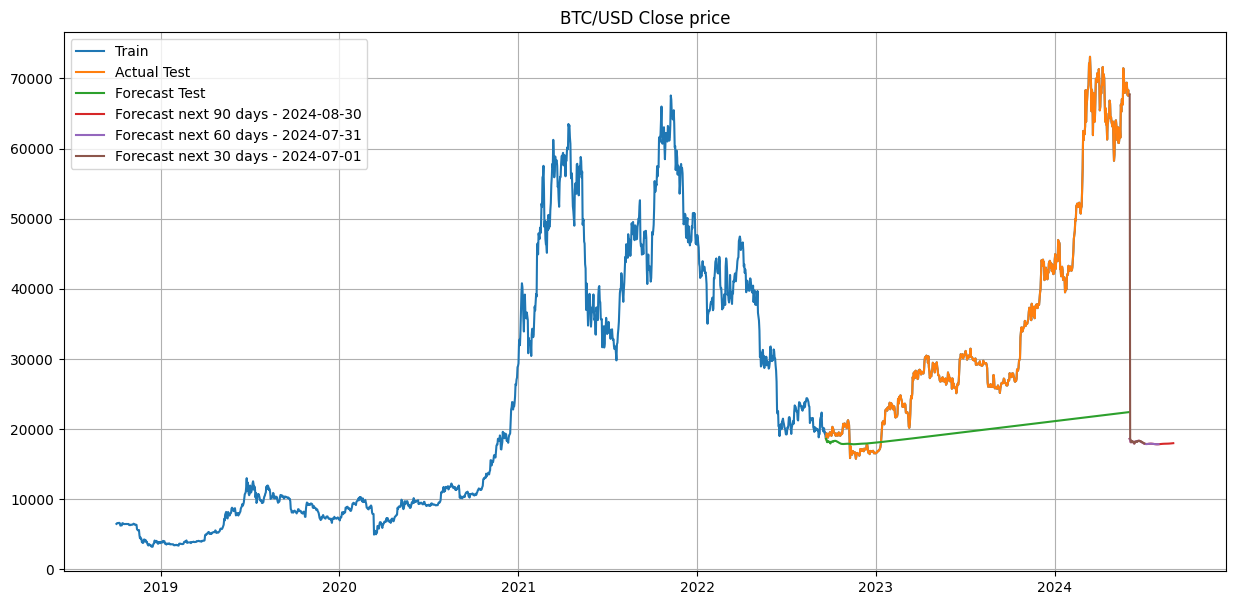

In [32]:
df_forecast_90 = df_results.loc[:, ['Close_forecast']].copy()
df_forecast_90.index = pd.to_datetime(df_forecast_90.index)

df_forecast_60 = df_forecast_90.head(60)
df_forecast_30 = df_forecast_90.head(30)

# Add last value of the original dataset to the forecast 30 days
df_forecast_30.loc[df_filtered.index[-1]] = df_filtered.tail(1).values[0][0]
df_forecast_30 = df_forecast_30.sort_index()

# Label the forecasted data
forecast_30_label = f"Forecast next 30 days - " + df_forecast_30.index[-1].strftime("%Y-%m-%d")
forecast_60_label = f"Forecast next 60 days - " + df_forecast_60.index[-1].strftime("%Y-%m-%d")
forecast_90_label = f"Forecast next 90 days - " + df_forecast_90.index[-1].strftime("%Y-%m-%d")

# Add last day of original data to the forecasted data
df_forecast_30 = pd.concat([df_filtered.tail(1), df_forecast_30])
df_forecast_30.index = pd.date_range(start=df_filtered.index.max(), periods=len(df_forecast_30))

# Plot the overall with connection to forecast
plt.figure(figsize=(15, 7))
plt.plot(df_filtered['Close'], label='Train')
plt.plot(df_test.index, df_test['Close'], label='Actual Test')
plt.plot(forecast_test_valid.index, forecast_test_valid['Close_forecast'], label='Forecast Test')
plt.plot(df_forecast_90.index, df_forecast_90['Close_forecast'], label=forecast_90_label)
plt.plot(df_forecast_60.index, df_forecast_60['Close_forecast'], label=forecast_60_label)
plt.plot(df_forecast_30.index, df_forecast_30['Close_forecast'], label=forecast_30_label)
plt.title('BTC/USD Close price')
plt.grid()
plt.legend()
plt.show()

In [33]:
# Model Evaluation
def calculate_metrics(y_true, y_pred):
    rmse = np.sqrt(np.mean((y_true - y_pred)**2))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    smape = np.mean((np.abs(y_pred - y_true) * 200 / (np.abs(y_pred) + np.abs(y_true))))
    return rmse, mape, smape

# Calculate metrics
rmse, mape, smape = calculate_metrics(df_test['Close'], forecast_test_valid['Close_forecast'])
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}")
print(f"SMAPE: {smape:.2f}")

RMSE: 20608.81
MAPE: 34.19
SMAPE: 44.80
